In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

import matplotlib.pyplot as plt

In [2]:
file1 = 'x1_trainData.npy'
x1_train = np.load(file1, allow_pickle=True)

In [3]:
x1_train.shape

(50, 2)

In [4]:
file2 = 'x2_trainData.npy'
x2_train = np.load(file1, allow_pickle=True)

In [5]:
x2_train.shape

(50, 2)

In [6]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
#x1_train = x[0:49, :] # class A
#x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [7]:
sv = Statevector.from_label('0' * n)

In [8]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(params[i], i)
    circuit.cx(0,1)
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(params[i+2], i)
    circuit.cx(0,1)
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(params[i+4], i)
    circuit.cx(0,1)
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(params[i+6], i)

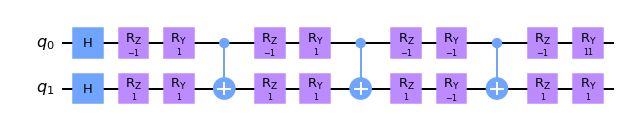

In [9]:
cir = QuantumCircuit(2)
final_circuit(cir, [-1,1],[1,1,1,1,-1,-1,11,1])
cir.draw('mpl')

In [10]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 8  # num of trainable params
for i in range(100):
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Data/4Layers/Layer4Easy/quantum_loss_easy_layer4random_%d.npy' %i
    f2 = 'Data/4Layers/Layer4Easy/opt_params_easy_layer4random_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546  ]
[0.7259857671230782, 0.7236313305063383, 0.7328316518589182, 0.7290427784455781, 0.7171564048675911, 0.7096627900114619, 0.7110888128737429, 0.7160596629934572, 0.7175652095392883, 0.713374095135165, 0.7058431985418828, 0.699010902210021, 0.6956830747325968, 0.6959085610915515, 0.697538044111936, 0.6983507427103676, 0.6977680807115634, 0.6967653243914493, 0.6965092519625732, 0.6970646980032978, 0.6973871963728147, 0.696714834397077, 0.6955473394007348, 0.6949671330110319, 0.6953779032701, 0.6961375157010192, 0.6963585209611644, 0.69585043883449, 0.6951663252323015, 0.694858232663396, 0.6948514229570345, 0.6946536438589195, 0.6940869534360017, 0.6935370092593699, 0.693432368791852, 0.6936978334425483, 0.6938927428311881, 0.6938000793594283, 0.6936419096921506, 0.6936876402613593, 0.693858456536166, 0.6938763956026212, 0.6936956079509945, 0.6935517831472174, 0.6935936219210717, 0.6936871906

[0.726140410201529, 0.7254679675415703, 0.7287079449859702, 0.7205530258592454, 0.7121025659744019, 0.7096221094586681, 0.7103562545767366, 0.7100180180922867, 0.7072989938413411, 0.7032162929328676, 0.6996816969185434, 0.6981041331621449, 0.6981679219863682, 0.6982618496230204, 0.6973877908124001, 0.6959242991948141, 0.694826310963074, 0.6946192838050428, 0.6950309001097479, 0.6953749566658272, 0.6951996996314924, 0.6945762441616553, 0.6939477983504361, 0.6937359484064628, 0.6939606570097687, 0.6942104057603453, 0.6940763889972134, 0.6936090507810365, 0.6932552022890947, 0.6933431288715463, 0.6936868888281685, 0.6938131672386066, 0.6935806752976741, 0.6933253752130194, 0.6933523458298742, 0.6935314768444336, 0.6935374527952848, 0.6933352081077837, 0.6931942079326034, 0.693273479035294, 0.6934085087237815, 0.6933846290375825, 0.6932496506286003, 0.693201229503301, 0.6932762509287318, 0.6933237203809307, 0.6932607459967285, 0.6931889089480064, 0.6932104409188118, 0.6932634441867765, 0.6

[0.7291474423052651, 0.7115565849868307, 0.7061173110589685, 0.7120924600180228, 0.7077800094891775, 0.7009006810500472, 0.7009920254129863, 0.7042896356886481, 0.7038101595666544, 0.7001549655530193, 0.6980651349096163, 0.699355428150746, 0.7003767835948932, 0.6985795590037982, 0.6964399689608323, 0.696506633709305, 0.6977035148608745, 0.6975953458895161, 0.6960779056351929, 0.6950475687841039, 0.6954546641734477, 0.6959806664830124, 0.6953494466963364, 0.694365580201011, 0.6942934767793897, 0.694776555771301, 0.6946531411185498, 0.6939519649221431, 0.6936757465276904, 0.6940195374235115, 0.694114033210359, 0.6936874587043068, 0.693465858747166, 0.6937177990056914, 0.6938267087561918, 0.6935353249652744, 0.6933653131071307, 0.6935417262600648, 0.6936050388858199, 0.6934027212213176, 0.6933464562948808, 0.6935055007112149, 0.6935146760037816, 0.6933737844282534, 0.6933907293505431, 0.6934976881220046, 0.6934456090872607, 0.6933602045266025, 0.6934143786285009, 0.6934487894349874, 0.693

[0.7019657233128312, 0.7056207029413037, 0.7084113006682267, 0.7039307473788464, 0.6986669902458247, 0.6969544552210514, 0.6978659715350263, 0.697875237080114, 0.6962455027455066, 0.6951938328421883, 0.696169413311329, 0.6964653521308959, 0.695148697978934, 0.6945044673548872, 0.695187461983355, 0.6955017039267436, 0.6947834527626398, 0.6943073927250897, 0.6948209176037057, 0.6950920437920842, 0.694550917857597, 0.6943136478526073, 0.6947022645539667, 0.6947477197135129, 0.6943083095087705, 0.694223102481694, 0.6945343364098185, 0.6944682183371423, 0.6941953513880594, 0.6942997516806932, 0.6944696366153251, 0.6943018750689446, 0.6941502610134391, 0.6942620388843985, 0.6942753740260764, 0.69410782969671, 0.6940840652402893, 0.6941704782883953, 0.6941200438937539, 0.694020346465988, 0.6940427609832888, 0.6940707648054624, 0.6939956521553567, 0.6939445265308017, 0.6939724120547163, 0.693966337483253, 0.6939097972877554, 0.6938969032750407, 0.6939183669601278, 0.6938970855325439, 0.6938584

[0.9943247200145382, 0.8721187977137136, 0.8026104325543025, 0.766178568005802, 0.7500037955129027, 0.7462134866664407, 0.7478176719247412, 0.7491939373822604, 0.7477986988812758, 0.7433719461121444, 0.7366387424041295, 0.7287506950093963, 0.7211331464321262, 0.7153146312829363, 0.7125057437639302, 0.7129825852795088, 0.7157087343434564, 0.7186915530673091, 0.7199726020059799, 0.7185419058665853, 0.7146411903075031, 0.7094588193967071, 0.7045027153768469, 0.7009682419611702, 0.6993476377998702, 0.6993941764183643, 0.7003863845364053, 0.7015089535030415, 0.7021527375606275, 0.7020392781477187, 0.7011976913966421, 0.6998669437186874, 0.6983804552464293, 0.6970593659287022, 0.6961281892640343, 0.6956652497081312, 0.6956004390032372, 0.6957618569717345, 0.6959539474294973, 0.6960332275904411, 0.6959497541597424, 0.6957417882748874, 0.6954944820627069, 0.6952888844631617, 0.6951660086759291, 0.6951187141809726, 0.6951077685663957, 0.6950879412190518, 0.6950296636985669, 0.6949282053247565, 

[0.7501812959342051, 0.7316590447045105, 0.7165953621596646, 0.7135638965109298, 0.7198360247521027, 0.7257418147469921, 0.7253462360215649, 0.7194890634368997, 0.7120980592373143, 0.7070000411647841, 0.705562892273628, 0.7058152102226, 0.7054392770910627, 0.7047843095203931, 0.7052394662696496, 0.7066448322213814, 0.7074424254142655, 0.7067651357582371, 0.7053129228229598, 0.704279123250091, 0.7039471369503313, 0.7035193762134198, 0.7023324085732018, 0.7007608669736307, 0.6996437709938064, 0.6991980259747907, 0.698864168674342, 0.6982123069202777, 0.6975337708419816, 0.6972838846666356, 0.6973086399713786, 0.697073779754882, 0.6964987296057454, 0.6959990885160988, 0.6957538775223168, 0.6954721067681048, 0.6949740606606248, 0.6945054612085424, 0.6942931058122928, 0.6941958370786836, 0.694020462654627, 0.693858688629022, 0.693869362170975, 0.6939753812409194, 0.6940096922473736, 0.6939908666220056, 0.6940350414599797, 0.6941211521740834, 0.6941376514126664, 0.6940799973099716, 0.6940344

[0.7303020272761076, 0.7086257391471666, 0.7090330279039531, 0.715629731367753, 0.7121801448530135, 0.7056436838307079, 0.7042070453609182, 0.7073546019314132, 0.7082550579273713, 0.7049237190938772, 0.7011767935712335, 0.7005165598080386, 0.7020764223944806, 0.702302398390185, 0.7001370586834355, 0.6979035732948957, 0.6977964359571074, 0.6989051545455819, 0.6987179830431615, 0.697105323633667, 0.6960958979035223, 0.6965606398705583, 0.6970948106832183, 0.6964576155452038, 0.6953952883596678, 0.6952398860803369, 0.6958351480575773, 0.6959360446782444, 0.695330450326873, 0.6949623651143239, 0.6952279191259406, 0.6954514122304254, 0.6951433207383121, 0.6947354238843275, 0.6947525866709047, 0.6949805897589435, 0.6949198082268165, 0.6946225997521086, 0.6944975335873235, 0.6945879848396694, 0.6945729318804444, 0.6943594457793809, 0.6942080628615824, 0.6942523974487996, 0.6942851954951069, 0.6941530023922533, 0.6940082195964768, 0.6939950023331347, 0.6940033176460507, 0.6939110990761208, 0.6

[0.9095662424415601, 0.8064445613483778, 0.7883374664828018, 0.8038930442062998, 0.8042019583301525, 0.7787361819907522, 0.7404564912079679, 0.7085098641628754, 0.6970511279074185, 0.7077813379494845, 0.7272696413184728, 0.7375458369281251, 0.7324687424545889, 0.7183863970525916, 0.7049998808173654, 0.6987860466803609, 0.7007687740974115, 0.7074290763745111, 0.7136387171316302, 0.7157565139274754, 0.713062243290637, 0.7073607471396606, 0.7016278625682433, 0.6984485315962266, 0.6987659741032276, 0.7014619020208479, 0.7041373090850982, 0.7047322580030301, 0.7028128553539225, 0.6996066321234855, 0.6969676512341313, 0.6961296729535319, 0.6970235255649293, 0.6984933841699774, 0.6991923299347058, 0.6984992172244101, 0.6968305026540232, 0.6952173439010251, 0.694527311253237, 0.6948856866049258, 0.6956742891676487, 0.6960709000468435, 0.6956851795354866, 0.6947915951797539, 0.6940264034723178, 0.6938482359822931, 0.6942024458322841, 0.6946282832320988, 0.6946813964789146, 0.6942942831685325, 0

[1.0103534506360183, 0.8723491708341038, 0.774784458127545, 0.7240166942396775, 0.7182794265260836, 0.742764362853165, 0.7716470787930683, 0.7859226183060702, 0.7828034699775824, 0.7680684341584716, 0.7487348492354368, 0.7303279565548698, 0.7162556467424885, 0.7079583977929638, 0.7052795382508531, 0.7068625708917736, 0.7106522669991253, 0.7145090790947062, 0.7167880104934348, 0.7166994964831653, 0.7143431954792555, 0.7104476267048129, 0.7059867970337576, 0.7018559498507357, 0.6986897653142734, 0.6968075085311639, 0.6962315921537285, 0.6967391745098717, 0.6979338435316699, 0.6993386126912812, 0.7005035324381396, 0.7011049094450472, 0.7010075330324793, 0.7002723642648381, 0.699110688431645, 0.6978046624119125, 0.6966213616913383, 0.6957458497922996, 0.6952486074740151, 0.6950905936460804, 0.6951567968544444, 0.6953038592585957, 0.6954068414218274, 0.6953930087742373, 0.6952556228199098, 0.6950445899433193, 0.6948380542290908, 0.6947046856175865, 0.6946723447070601, 0.6947169015242946, 0.

[0.801606296686522, 0.7348105991734021, 0.7074148483042176, 0.7037732486499061, 0.711252630340922, 0.720183830594244, 0.7257158651931322, 0.7270300298068645, 0.7249488754261137, 0.7204882839306428, 0.7147112713404873, 0.7087964728922509, 0.7037521431063389, 0.7001017756369272, 0.6977959910005631, 0.6964329238758719, 0.695654929029326, 0.6953568859457452, 0.6955727904051017, 0.696256122171778, 0.6971795768576386, 0.6980236433750313, 0.6985579501806012, 0.6987469114792428, 0.6987078205198469, 0.6985823849394984, 0.698430364644086, 0.6982220058625656, 0.6979183652949801, 0.6975462878324511, 0.697193200197515, 0.6969362200318229, 0.6967770271179958, 0.6966437899965109, 0.696458993897707, 0.6962054201109753, 0.6959277183822015, 0.6956790994287243, 0.6954712002745598, 0.6952746424217987, 0.6950637862166097, 0.6948523022467625, 0.694678770389135, 0.6945623320042504, 0.6944825962322432, 0.6944071211361411, 0.6943303988720971, 0.6942751243574883, 0.6942571802781979, 0.694261964022755, 0.6942624

[0.7857049828340772, 0.7351401745600615, 0.7204494689224211, 0.7205557610653393, 0.7207041874890551, 0.7183806495156125, 0.7166890635357877, 0.7169369508036335, 0.7168399869439316, 0.7133896800354518, 0.7068913633706554, 0.7005927804565845, 0.6974953758274441, 0.6979809306341755, 0.6998657574243218, 0.7007528804138669, 0.7000145240670919, 0.6986580124072613, 0.6979987787883876, 0.6984569084001764, 0.6992946484445199, 0.6994517705207867, 0.6985620498690165, 0.6971515649134846, 0.6960780221160059, 0.6958368612772271, 0.6962403430445825, 0.6966666930648041, 0.6966303522485727, 0.696136455954113, 0.6955530254675335, 0.6952182871322471, 0.6951595318721694, 0.695133252623753, 0.6949021992889108, 0.6944671448729189, 0.6940500934669216, 0.6938775639718817, 0.6939788397416623, 0.6941772663575394, 0.6942657234634155, 0.6941829625894472, 0.6940265306109785, 0.693920068874463, 0.6938873341852871, 0.6938521036863068, 0.6937438433854705, 0.6935845629370889, 0.693466053908655, 0.6934516274452323, 0.6

[0.7256837327202729, 0.7036998828363294, 0.7046903713284455, 0.7064718931984285, 0.6986548902016603, 0.6945126365161998, 0.6973723396808803, 0.6995255183420422, 0.6975244524725849, 0.694899319910961, 0.6947646363270984, 0.6963998968589478, 0.6972247503736735, 0.6965063255140336, 0.6954149964855414, 0.6951154284289374, 0.6955292411344425, 0.6959073682008262, 0.6957952841231578, 0.6952367383674525, 0.6946825276393502, 0.694453348356438, 0.6945135222899858, 0.6946166112781659, 0.6944803309970191, 0.6940976426217134, 0.6937517724741384, 0.6937147026371768, 0.6939380811287573, 0.6940548085376512, 0.693862727008041, 0.6935771205163391, 0.6935148811088057, 0.6936863343403197, 0.6938024861139033, 0.6936981976994369, 0.693514646296044, 0.6934458221754488, 0.6934956431941931, 0.6935320321041697, 0.6934862470369513, 0.6933984538084349, 0.6933323164336646, 0.69331898798985, 0.693345625410759, 0.693361122316163, 0.6933258988761816, 0.6932719279806556, 0.6932654468975613, 0.6933059190435402, 0.69332

[0.7794651028512612, 0.738538227390102, 0.7303780246026856, 0.7341826774995269, 0.7371809903862692, 0.7351141011013079, 0.7285817738601348, 0.7198217149554452, 0.7111743535916847, 0.7044958743712191, 0.7009383737764895, 0.7008655017361618, 0.7036785491680123, 0.7076264350804842, 0.7102335809937188, 0.7097420634750801, 0.7063272943191137, 0.7017747940738641, 0.6981911880391884, 0.696834393506777, 0.6976394662792849, 0.6995353470502813, 0.7012026409404268, 0.7017545821295709, 0.701043987517817, 0.6995851718001499, 0.6981993714420192, 0.6975332005128958, 0.697675205557023, 0.6981427747516494, 0.6983119776696718, 0.6979416378235076, 0.697316971449824, 0.6969283935069218, 0.6970225627350117, 0.6974150977040927, 0.6976862483087143, 0.6975406455366704, 0.6970177798160603, 0.6964268749121154, 0.6961004484070595, 0.6961571398555972, 0.6964382646914121, 0.6966558693477318, 0.6966221187172801, 0.6963679405468484, 0.6960748243047294, 0.6959065010890377, 0.6958890231190823, 0.6959217187824467, 0.69

[ 1.71378328 -1.04543464 -0.03971537  1.01817777  1.06241752  1.76766882
  0.3286464   0.04627216]
[ 0.64622068 -0.94776404 -0.57845872  0.23684354 -0.80343107  0.24026262
 -0.89221956  0.92130812]
[0.7366440756989187, 0.7173343163105487, 0.7334688975068143, 0.7409501789630144, 0.7326008963260391, 0.7183831864803537, 0.7072730180521034, 0.7036413688872956, 0.7067662796710451, 0.7124279354246242, 0.7161193929982431, 0.7156869109543301, 0.7117330837311306, 0.706465044012056, 0.7022966547552452, 0.7007318967481072, 0.7017238408035992, 0.7038047555299101, 0.705076663515176, 0.7044360827045392, 0.7021083902752888, 0.699260674226485, 0.6971731662512876, 0.6965243301066931, 0.6971149600272141, 0.6981123720254864, 0.6986274089141584, 0.6982431468447219, 0.6971783846790403, 0.6960501061145499, 0.695439944126373, 0.695538603648581, 0.6960702618276038, 0.6965266190179016, 0.6965326728866501, 0.6960774298618041, 0.6954645503571697, 0.6950539469466283, 0.6949987588266621, 0.6951629746863353, 0.6952

[0.767238382331977, 0.7023470813892121, 0.714068013416533, 0.7485316159484047, 0.7595411713320972, 0.7465039554547147, 0.7258706551959, 0.7091826696553925, 0.701123241605752, 0.7013170372145089, 0.7058500321672858, 0.7101727215980134, 0.7117584031956943, 0.7106420517097676, 0.7080034232323357, 0.704838287214352, 0.7018620542339523, 0.6995979257037201, 0.6982080505635028, 0.6975528229453117, 0.6974689334257721, 0.6979006467281443, 0.6987210638688234, 0.6995220097494921, 0.6997570614529336, 0.6991228410877374, 0.6977464585435371, 0.6960862431322608, 0.6947139054296604, 0.6940847987988232, 0.6943367283633017, 0.6951952899913161, 0.6960933413850161, 0.6964879806087461, 0.6961609395112884, 0.6952936655429722, 0.6943137846639719, 0.69364641761499, 0.6935059061207381, 0.6938168051352536, 0.6942943170653735, 0.6946287206335846, 0.694653104678731, 0.6943974855423556, 0.6940251539401171, 0.6937171350356873, 0.6935781628876153, 0.6936055842884622, 0.6937217876461937, 0.6938356421634737, 0.6938894

[0.7324276918615569, 0.714793042213109, 0.7140930893442604, 0.7147197417256297, 0.7149607647279765, 0.7128708313005033, 0.7087269855292482, 0.7043084227188374, 0.7011068617653301, 0.6998182675706134, 0.7002625906171146, 0.7016236284320218, 0.7029771125834171, 0.7037206262773631, 0.7036480410503142, 0.7028139584338368, 0.7014135459377897, 0.6997387096985221, 0.6981437690841843, 0.6969529310046437, 0.6963311077485372, 0.6962229546308453, 0.6964325581549113, 0.6967750654860931, 0.6971517599744651, 0.6974974549761768, 0.6977005741397785, 0.6976188802213238, 0.6971920379448693, 0.6965269648424329, 0.6958465468890657, 0.6953346285666181, 0.6950227022539708, 0.6948289694526827, 0.6946876357229087, 0.6945933038626816, 0.6945228998916886, 0.6943962953779804, 0.6941709518696321, 0.693932197017699, 0.6938181382742137, 0.6938576679798517, 0.6939452663255448, 0.6939864624903385, 0.6939779549791338, 0.6939272116094775, 0.6938117816706705, 0.6936623154502867, 0.6935770482994065, 0.6935950031355239, 0

[0.7480900633448786, 0.7158623617830715, 0.7220807473807632, 0.7342142459737466, 0.7369082579230021, 0.7296607417183634, 0.717609081938496, 0.70587121714015, 0.6978237266213653, 0.6947339019984323, 0.6959271055919278, 0.6994614371053797, 0.7031461696196313, 0.705506377595749, 0.7061357064804077, 0.7053888501009413, 0.7038682513301338, 0.7020596979454444, 0.7002164221030452, 0.698433962248672, 0.6967841277982169, 0.6953841297750377, 0.694373301232946, 0.6938452413445519, 0.6937947374147929, 0.6941105527574853, 0.6946130249048601, 0.695111379332702, 0.6954556385213564, 0.6955666775566881, 0.6954414379428671, 0.6951428746013749, 0.6947742049921706, 0.6944347173266675, 0.69417656834448, 0.6939945166698271, 0.6938585042382421, 0.6937552615066351, 0.6936969289857554, 0.693695616573695, 0.6937396502727828, 0.6937975782356844, 0.693837806621862, 0.693839505456609, 0.6937913633013716, 0.6936931271578581, 0.6935628621959888, 0.6934346486700352, 0.6933390765127615, 0.693283799356951, 0.6932559845

[0.820771515587008, 0.7777504674862715, 0.7664288798880399, 0.7712238641715768, 0.7690545819752401, 0.7546982537191965, 0.7364872835427296, 0.7233367410645053, 0.7182768199259325, 0.7176414592569995, 0.7160328624394411, 0.7111958208886461, 0.7042754380356518, 0.6980681482819591, 0.6952471995374462, 0.696678479852557, 0.7003891289162343, 0.702911293613863, 0.7024609659208536, 0.7000543107691405, 0.6978927687111549, 0.697429450273904, 0.698560043860795, 0.7000904719627777, 0.7008157523149968, 0.7002814105582117, 0.6988636394542371, 0.6973921551482346, 0.6966071895569721, 0.6966831222920429, 0.6971185049361428, 0.6971756148564388, 0.6965305751209246, 0.6954997677461024, 0.694681696785607, 0.6944303923419934, 0.6946173456777472, 0.6948127796635083, 0.6946725008739167, 0.6941975142016298, 0.6936874075042201, 0.6934592180703629, 0.6935703498317666, 0.6937868404558734, 0.6938287477804882, 0.6936401755374315, 0.6934072581727476, 0.6933375515632417, 0.6934536067950833, 0.6935989354768153, 0.693

[0.7873946158743361, 0.7290594701425581, 0.7164782929560879, 0.7282219137246522, 0.7444165264156563, 0.7550247847858711, 0.7575737899196068, 0.7531872132104692, 0.743761824706052, 0.731101696951934, 0.7178493079556654, 0.7074454645247913, 0.7027322211521876, 0.7039558610279415, 0.7084436102040915, 0.7124195671466305, 0.713191160480263, 0.7104598377985951, 0.7058722165092688, 0.7015715186081198, 0.6989344249875086, 0.6981169601472039, 0.6984271485176573, 0.6990152544398884, 0.6993183526616841, 0.6991447855412383, 0.6985505937065177, 0.6976918801274425, 0.6967704861472331, 0.6960187702917112, 0.6956105843057524, 0.6955427929634732, 0.6956255325590665, 0.6956222021736008, 0.6954269706407189, 0.6951234750141362, 0.6948831408837108, 0.6948078803147939, 0.6948548681672994, 0.6948861953439557, 0.6947822883804462, 0.6945295831240784, 0.6942294611279852, 0.6940283660896585, 0.6940160977382905, 0.6941612060654905, 0.6943298690756714, 0.6943766843935458, 0.6942434648042854, 0.6939970597565739, 0.

[0.7613840573849703, 0.7355730670335946, 0.7204722246543911, 0.7136087627529303, 0.709627433174261, 0.705365106361824, 0.7022367605959825, 0.7021485720385333, 0.7040253070709517, 0.7058089577125121, 0.7067253266273796, 0.7070018625952695, 0.7070516136528352, 0.7070202062628576, 0.7068203851488155, 0.7063347344835438, 0.7055084415554727, 0.7043778044346122, 0.7030806012433388, 0.7018075909504611, 0.7007017266064836, 0.6997782421816943, 0.6989327368431216, 0.6980395788931476, 0.6970695054489784, 0.6961263079706516, 0.6953670626970316, 0.6948713919568429, 0.694572991612072, 0.6943223915531185, 0.6940315579292564, 0.6937563726341207, 0.6936287182198658, 0.6937093880574657, 0.6939191550706185, 0.6941217360830286, 0.6942559176795189, 0.6943573580333994, 0.6944593236900249, 0.6945220462652695, 0.6944876559823829, 0.694365233342461, 0.694216484875924, 0.694078786981815, 0.6939443961646659, 0.6938082710545049, 0.6936978342054805, 0.6936414677662822, 0.6936288775925307, 0.6936236122975932, 0.693

[0.7752346265168419, 0.7435219588109335, 0.7200405671982141, 0.7064221008728908, 0.7012533517467118, 0.7008364575269682, 0.7027434874874872, 0.7055087028855216, 0.70690088801325, 0.7064238437920638, 0.7055719125008675, 0.7053989397306456, 0.7054993418710953, 0.7052957287415098, 0.7049926750836317, 0.7046471091060649, 0.7036955476460953, 0.7018929545055396, 0.6998626968003928, 0.6984596645011096, 0.6978340576920494, 0.6975434136637563, 0.6974778995548259, 0.6976563881394755, 0.6975711000440546, 0.6969036129972462, 0.6961281842707008, 0.6956742208961667, 0.6954046915902541, 0.6952642854642721, 0.6954386576800061, 0.6957501038334822, 0.6958212870259989, 0.6956914196722147, 0.695542575708613, 0.6952968003175483, 0.6950034804453208, 0.6948951572529894, 0.694896420983332, 0.6948644648822737, 0.6948860037875032, 0.6948779868785314, 0.6947362747776211, 0.6945972866815145, 0.694447329571818, 0.6942639244617458, 0.6941773449842898, 0.6941291420485329, 0.6940950917908486, 0.6941196450566147, 0.69

[0.745741486784058, 0.7199791102284985, 0.7186984945376084, 0.726369560870357, 0.7295752031136427, 0.7267917887086116, 0.7207830753861466, 0.7143971229069435, 0.7096026953786585, 0.7072728813223631, 0.7070849436086685, 0.7078211395070718, 0.7083581953643895, 0.7083235248818454, 0.7076701631784874, 0.7063628633225042, 0.704623963613602, 0.7028991065930826, 0.7015530621918782, 0.7006622367285806, 0.7000841800395977, 0.6996675573008504, 0.699298087005682, 0.6988348613504957, 0.6981884234472389, 0.6974724523015662, 0.6968989863185232, 0.696512969479131, 0.6962184788437008, 0.6959863236712959, 0.6958169165569185, 0.6956250342419823, 0.6953650240033545, 0.6951133011116848, 0.6949070538923031, 0.6947112638582734, 0.6945554722043257, 0.6944768649853583, 0.6944235313479038, 0.6943679345321202, 0.6943281166851466, 0.694267384858336, 0.6941661743306838, 0.6940626024314622, 0.6939517019073296, 0.6938284504767038, 0.6937295002318373, 0.6936503108098977, 0.6935832518045957, 0.6935473513780472, 0.693

[0.7213835040286461, 0.714680265712957, 0.7041405531053101, 0.7007394470707109, 0.7070778044873485, 0.7120299333567162, 0.7089917032190344, 0.7029334598611595, 0.6998352768107218, 0.6994936998307986, 0.6979716408286766, 0.6950481108486407, 0.6940220742629526, 0.6959726604711975, 0.6977686127354797, 0.6972572178643145, 0.6962525142793177, 0.6967832732958662, 0.6977754378985348, 0.6972240610114774, 0.6957193819464434, 0.6951639281801495, 0.6955403017684949, 0.6952400215092978, 0.6941719090567783, 0.6937424441266598, 0.6941708175085682, 0.6942549847862667, 0.693766861897589, 0.6936877994813209, 0.6941405697576792, 0.694219442577392, 0.6938618522987997, 0.6938309162197791, 0.6940811631075512, 0.6939667528035584, 0.6936529394837511, 0.6936736719002478, 0.6937831781489653, 0.6935955635953115, 0.6934356105853875, 0.6935370462292052, 0.6935485752890526, 0.6933954799209396, 0.6934011997099425, 0.6934936240266341, 0.6934232386853998, 0.6933612375640575, 0.6934353717515788, 0.6934349333105371, 0.

[0.7832899176354157, 0.7205609626778672, 0.70651227169208, 0.7259195504729096, 0.741467743793457, 0.7434335655486016, 0.736940298008171, 0.7276144994152364, 0.7192419473302484, 0.7129057211078562, 0.7086839756799812, 0.7071219852593984, 0.7087417273873007, 0.7125183247470371, 0.7157439358618908, 0.7162098824139956, 0.7136933917830087, 0.7093938815439238, 0.7048921149885682, 0.7014618061957428, 0.6997278993335674, 0.6996032941692206, 0.7004752791904196, 0.7015416313500522, 0.702122619470886, 0.7018435269390018, 0.7006951565047649, 0.6989922615745664, 0.6972296768481594, 0.6958744248126669, 0.695186465452426, 0.6951470463912135, 0.6955091184886222, 0.695930319627834, 0.6961250320464388, 0.695967736393881, 0.6955057966407846, 0.6948990129429135, 0.6943367299040912, 0.6939703005632292, 0.6938670943280804, 0.6939891705432073, 0.6942121758968872, 0.694387994042768, 0.6944190096665049, 0.6942963783052537, 0.6940826127940318, 0.6938626337229781, 0.6937034162970881, 0.6936382996870278, 0.693665

[0.7286963949055467, 0.7192322999752903, 0.7213477422292859, 0.7249146913214186, 0.7233639391806794, 0.7193682010707615, 0.7163798594450291, 0.7154876054447818, 0.7159467836907525, 0.716611548176903, 0.7164542303693113, 0.7149356430096638, 0.7123158861775305, 0.7094581674263604, 0.7072388874806694, 0.7059101442817715, 0.7049315815322724, 0.703593309219563, 0.7017652130732235, 0.6999271373441747, 0.6986544929508455, 0.6981360463964692, 0.6980845528274162, 0.6980722428852212, 0.6979079756887405, 0.6976823695576314, 0.6975599923204482, 0.6975832205848488, 0.6976309283850191, 0.6975259979619776, 0.6971868304639353, 0.6966998765550672, 0.6962580022057812, 0.6960099640923211, 0.6959413483297113, 0.6958993257272229, 0.6957486003571206, 0.6954995769799958, 0.6952758971818809, 0.6951614437143491, 0.6951008284527481, 0.6949678600688439, 0.6947193097346848, 0.6944471556421244, 0.6942718729374345, 0.6942079564546413, 0.6941597461082247, 0.6940476578958077, 0.6938991597863357, 0.6937928283957069, 0

In [11]:
loss_eqnn_d1 = np.load('Data/4Layers/Layer4Easy/quantum_loss_easy_layer4random_1.npy')

In [12]:
loss_eqnn_d1.shape

(100,)

In [13]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Data/4Layers/Layer4Easy/quantum_loss_easy_layer4random_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [14]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 4 Layers (Data Reuploading, Qubits = 2, Easy Model)')

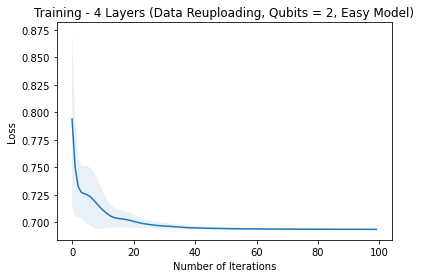

In [15]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 4 Layers (Data Reuploading, Qubits = 2, Easy Model)")